<a href="https://colab.research.google.com/github/belanasaikiran/Team-6-Big-Data-Project/blob/main/temp/Xception_Car_Model_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import warnings
import seaborn as sns
import matplotlib.pylab as plt
import PIL
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import f1_score
from keras import backend as K
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import *
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

warnings.filterwarnings('ignore')
K.image_data_format()

'channels_last'

In [2]:
BATCH_SIZE = 32
EPOCHS = 50
k_folds = 2
TTA_STEPS = 5
PATIENCE = 6
SEED = 2019
BASE_MODEL = Xception
IMAGE_SIZE = 299

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip gdrive/MyDrive/2019-3rd-ml-month-with-kakr.zip > /dev/null # output to null

In [5]:
DATA_PATH = '/content/'

TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test')

df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))

model_path = '/content/'
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [6]:

model_path = '/contnet/'
if not os.path.exists(model_path):
    os.mkdir(model_path)
def crop_boxing_img(img_name, margin=0, size=(IMAGE_SIZE,IMAGE_SIZE)):
    if img_name.split('_')[0] == 'train':
        PATH = TRAIN_IMG_PATH
        data = df_train
    else:
        PATH = TEST_IMG_PATH
        data = df_test

    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)

    width, height = img.size
    x1 = max(0, pos[0] - margin)
    y1 = max(0, pos[1] - margin)
    x2 = min(pos[2] + margin, width)
    y2 = min(pos[3] + margin, height)

    return img.crop((x1, y1, x2, y2)).resize(size)

In [7]:
%%time
TRAIN_CROPPED_PATH = '/content/cropped_train'
TEST_CROPPED_PATH = '/content/cropped_test'

if (os.path.isdir(TRAIN_CROPPED_PATH) == False):
    os.mkdir(TRAIN_CROPPED_PATH)

if (os.path.isdir(TEST_CROPPED_PATH) == False):
    os.mkdir(TEST_CROPPED_PATH)

for i, row in df_train.iterrows():
    cropped = crop_boxing_img(row['img_file'])
    cropped.save(os.path.join(TRAIN_CROPPED_PATH, row['img_file']))

for i, row in df_test.iterrows():
    cropped = crop_boxing_img(row['img_file'])
    cropped.save(os.path.join(TEST_CROPPED_PATH, row['img_file']))

CPU times: user 2min 6s, sys: 4.97 s, total: 2min 11s
Wall time: 2min 11s


In [8]:
df_train['class'] = df_train['class'].astype('str')
df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]

In [9]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [10]:
def get_callback(model_name, patient):
    ES = EarlyStopping(
        monitor='val_f1_m',
        patience=patient,
        mode='max',
        verbose=1)
    RR = ReduceLROnPlateau(
        monitor = 'val_f1_m',
        factor = 0.5,
        patience = patient / 2,
        min_lr=0.000001,
        verbose=1,
        mode='max')
    MC = ModelCheckpoint(
        filepath=model_name,
        monitor='val_f1_m',
        verbose=1,
        save_best_only=True,
        mode='max')

    return [ES, RR, MC]

In [11]:
def get_model(model_name, iamge_size):
    base_model = model_name(weights='imagenet', input_shape=(iamge_size,iamge_size,3), include_top=False)
    #base_model.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(2048, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dropout(0.15))

    model.add(layers.Dense(196, activation='softmax', kernel_initializer='lecun_normal'))
    #model.summary()

    optimizer = optimizers.Nadam(lr=0.0003)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc', f1_m, precision_m, recall_m])

    return model

In [12]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser


In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #featurewise_center= True,  # set input mean to 0 over the dataset
    #samplewise_center=True,  # set each sample mean to 0
    #featurewise_std_normalization= True,  # divide inputs by std of the dataset
    #samplewise_std_normalization=True,  # divide each input by its std
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.3,
    shear_range=0.5,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    preprocessing_function = get_random_eraser(v_l=0, v_h=255),
    )

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    #featurewise_center= True,  # set input mean to 0 over the dataset
    #samplewise_center=True,  # set each sample mean to 0
    #featurewise_std_normalization= True,  # divide inputs by std of the dataset
    #samplewise_std_normalization=True  # divide each input by its std
    )
test_datagen = ImageDataGenerator(
    rescale=1./255,
    #featurewise_center= True,  # set input mean to 0 over the dataset
    #samplewise_center=True,  # set each sample mean to 0
    #featurewise_std_normalization= True,  # divide inputs by std of the dataset
    #samplewise_std_normalization=True,  # divide each input by its std
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.3,
    shear_range=0.5,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    preprocessing_function = get_random_eraser(v_l=0, v_h=255),
    )

In [17]:
# skf = StratifiedKFold(n_splits=k_folds)
skf = KFold(n_splits=k_folds)

In [18]:
%%time
j = 1
model_names = []
for (train_index, valid_index) in skf.split(
    df_train['img_file'],
    df_train['class']):


    traindf = df_train
    validdf = df_train.iloc[valid_index, :].reset_index()

    print("=========================================")
    print("====== K Fold Validation step => %d/%d =======" % (j,k_folds))
    print("=========================================")

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=traindf,
        directory=TRAIN_CROPPED_PATH,
        x_col='img_file',
        y_col='class',
        target_size= (IMAGE_SIZE, IMAGE_SIZE),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=True
        )

    valid_generator = valid_datagen.flow_from_dataframe(
        dataframe=validdf,
        directory=TRAIN_CROPPED_PATH,
        x_col='img_file',
        y_col='class',
        target_size= (IMAGE_SIZE, IMAGE_SIZE),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=True
        )

    model_name = model_path + str(j) + '_' + 'Xception' + '.hdf5'
    model_names.append(model_name)

    model = get_model(BASE_MODEL, IMAGE_SIZE)

    try:
        model.load_weights(model_name)
    except:
        pass

    history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(traindf.index) / BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=valid_generator,
        validation_steps=len(validdf.index) / BATCH_SIZE,
        verbose=1,
        shuffle=False,
        callbacks = get_callback(model_name, PATIENCE)
        )

    j+=1

====== K Fold Validation step => 1/2 =======
Found 9990 validated image filenames belonging to 196 classes.
Found 4995 validated image filenames belonging to 196 classes.


Epoch 1/50
313/312 [==============================] - ETA: 0s - loss: 5.2206 - acc: 0.0106 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 1: val_f1_m improved from -inf to 0.00000, saving model to /contnet/1_Xception.hdf5
312/312 [==============================] - 250s 710ms/step - loss: 5.2206 - acc: 0.0106 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 5.4656 - val_acc: 0.0114 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - lr: 0.0010
Epoch 2/50
313/312 [==============================] - ETA: 0s - loss: 5.1508 - acc: 0.0114 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 2: val_f1_m improved from 0.00000 to 0.01037, saving model to /contnet/1_Xception.hdf5
312/312 [==============================] - 222s 710ms/step - loss: 5.1508 - acc: 0.0114 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 29.0547 - val_acc: 0.0088 - val_f1_m: 0.0104 

Epoch 1/50
313/312 [==============================] - ETA: 0s - loss: 5.2801 - acc: 0.0071 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 1: val_f1_m improved from -inf to 0.00000, saving model to /contnet/2_Xception.hdf5
312/312 [==============================] - 250s 708ms/step - loss: 5.2801 - acc: 0.0071 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 5.2769 - val_acc: 0.0082 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - lr: 0.0010
Epoch 2/50
313/312 [==============================] - ETA: 0s - loss: 5.2775 - acc: 0.0083 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 2: val_f1_m did not improve from 0.00000
312/312 [==============================] - 221s 708ms/step - loss: 5.2775 - acc: 0.0083 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 5.2759 - val_acc: 0.0082 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_

In [19]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_acc', 'val_f1_m', 'val_precision_m', 'val_recall_m', 'lr'])


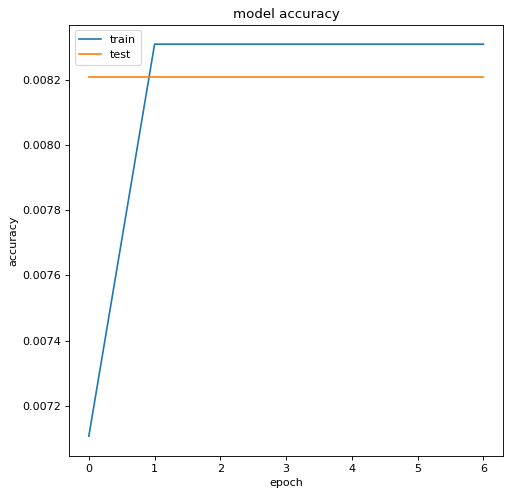

In [20]:
plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

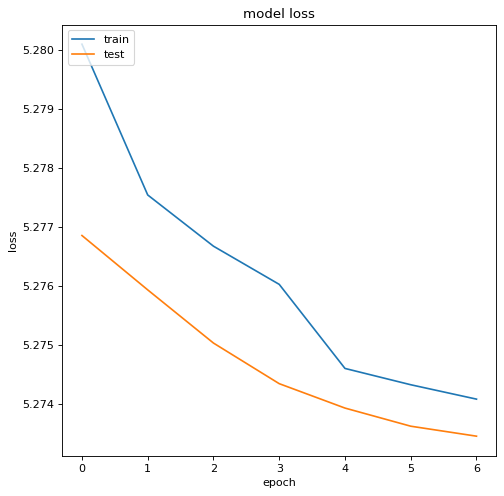

In [21]:
plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

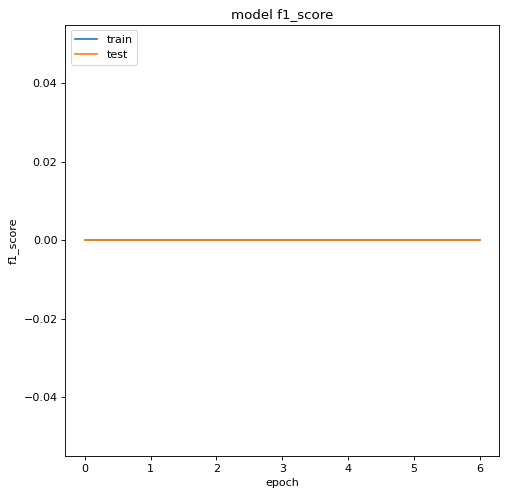

In [22]:
plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=TEST_CROPPED_PATH,
    x_col='img_file',
    y_col=None,
    target_size= (IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 6150 validated image filenames.


In [25]:
prediction = []
for i, name in enumerate(model_names):
    model = get_model(BASE_MODEL, IMAGE_SIZE)
    model.load_weights(name)

    preds = []
    for j in range(TTA_STEPS):
        test_generator.reset()
        pred = model.predict_generator(
            generator=test_generator,
            steps = len(df_test)/BATCH_SIZE,
            verbose=1
        )
        preds.append(pred)
    pred_tta = np.mean(preds, axis=0)
    prediction.append(pred_tta)

y_pred = np.mean(prediction, axis=0)

192/192 [==============================] - 126s 653ms/step


192/192 [==============================] - 125s 648ms/step


In [26]:
preds_class_indices=np.argmax(y_pred, axis=1)

In [27]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
final_pred = [labels[k] for k in preds_class_indices]

In [30]:
final_result = pd.read_csv(os.path.join(DATA_PATH, 'final_result.csv'))
final_result["class"] = final_pred
final_result.to_csv("final_result.csv", index=False)
final_result.head()

,img_file,class
0,test_00001.jpg,124
1,test_00002.jpg,98
2,test_00003.jpg,157
3,test_00004.jpg,94
4,test_00005.jpg,18


In [33]:
class_dfa = pd.read_csv("/content/class.csv")
class_dfa.head()

,id,name
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012


test_02797.jpg
181
class_name:  Suzuki Kizashi Sedan 2012
test_04161.jpg
71
class_name:  Chevrolet Monte Carlo Coupe 2007
test_03069.jpg
142
class_name:  Isuzu Ascender SUV 2008
test_05562.jpg
82
class_name:  Dodge Caliber Wagon 2012
test_04947.jpg
176
class_name:  Rolls-Royce Phantom Sedan 2012
test_01634.jpg
119
class_name:  GMC Yukon Hybrid SUV 2012
test_05730.jpg
72
class_name:  Chevrolet Malibu Sedan 2007
test_06005.jpg
115
class_name:  Ford E-Series Wagon Van 2012
test_02567.jpg
145
class_name:  Jeep Wrangler SUV 2012
test_03643.jpg
94
class_name:  Dodge Durango SUV 2007


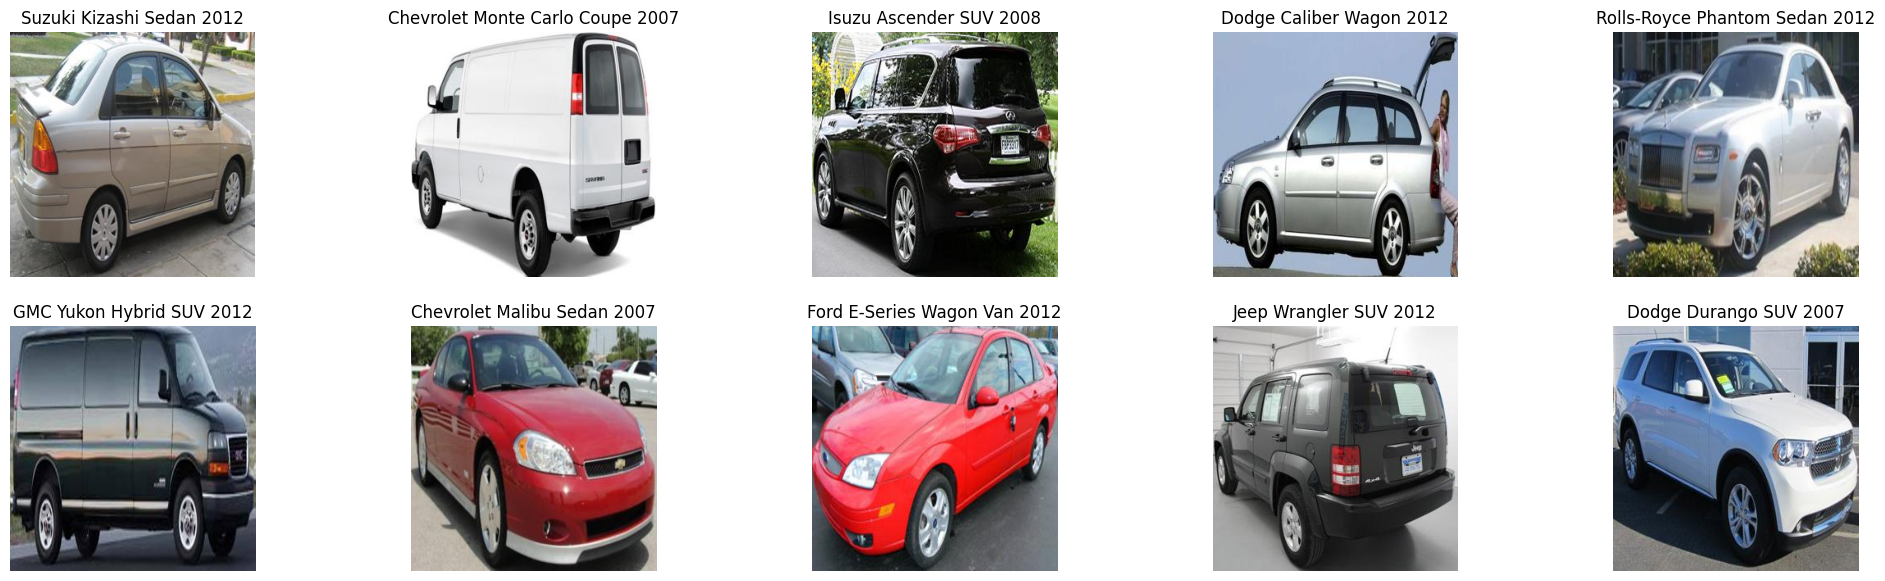

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

# Read the final_result.csv file
final_result = pd.read_csv("/content/final_result.csv")

# Get a random sample of 10 images
images = final_result.sample(n=10)

# Read the class.csv file
class_dfa = pd.read_csv("/content/class.csv")

# Create a figure with a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(25, 7))

# Iterate through the images and display them
for idx, row in enumerate(images.iterrows()):
    # row[0] is the index, row[1] is the data
    image_file = row[1]["img_file"]
    print(row[1]["img_file"])
    print(row[1]["class"])

    # Read the image
    image_path = os.path.join("/content/cropped_test/", image_file)
    image = cv2.imread(image_path)

    # Convert color from BGR to RGB (since cv2 reads images in BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get the class name
    index = row[1]["class"]
    class_name = class_dfa["name"].iloc[index]  # Adjusted to index without +1 assuming zero-based indexing in class_dfa
    print("class_name: ", class_name)

    # Display the image
    ax = axes[idx // 5, idx % 5]  # Use idx which is 0-9 for subplots
    ax.imshow(image)
    ax.set_title(class_name)
    ax.axis("off")

# Show the plot
plt.show()
